## Set up environment paths

In [220]:
import setup
setup.main()
RAW_DIR, BINNED_DIR = setup.get_data_dir()

%load_ext autoreload
%autoreload 2

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
The raw data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/raw.
The binned data is located in the directory:
/Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [221]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import viz
import neuralgeom.datasets.utils as utils
import neuralgeom.datasets.experimental as experimental
import os
from lovely_numpy import lo

## Inspect Raw Data

In [222]:
expt_id = "34"

expt = utils.loadmat(os.path.join(RAW_DIR, f"expt{expt_id}.mat"))

metadata = list(expt["x"].keys())
print(f"You can find metadata about:\n {metadata}.")

You can find metadata about:
 ['rat', 'day', 'epoch', 'type', 'finalGain', 'rosdata', 'clust', 'specGain'].


In [223]:
rat_id = expt["x"]["rat"]
print(f"The data was collected from rat {rat_id}.")

day = expt["x"]["day"]
print(f"The data was collected on day {day}.")

n_cells = len(expt["x"]["clust"])
print(f"There are {n_cells} neurons recorded in this experiment.")

epoch = expt["x"]["epoch"]
print(f"Epoch =  {epoch}")

final_gain = expt["x"]["finalGain"]
print(f"Final gain =  {final_gain}")

if np.unique(expt["x"]["rosdata"]["gain"]).size == 1:
    print("The gain is constant throughout the experiment")
else:
    print("The gain changes throughout the experiment")
    plt.plot(expt["x"]["rosdata"]["gain"])
    plt.title("Gain")

The data was collected from rat 637.
The data was collected on day 6.
There are 40 neurons recorded in this experiment.
Epoch =  m1
Final gain =  1
The gain is constant throughout the experiment


## Define experimental variables


- startTs: time in microseconds 

- stopTs: time in microseconds 

- encTimes: "encoder" times 

- encAngle: recorded angles of rat

- subepochs: "m1" exprrimental session, + periods where gain eitehr takes a different value or changes

- landAngle: angle of landmark frame

- gain: 

- vel: velocity of rat (degrees/s - close to cm/s here)

- relAngle: encAngle - landAngle

- landOffTime: when landmamarks turned off

- landOffAngle: encAngle(landOfftime) -- encAngle[landOffIdx]

- landOffIdx: index of lanfOffAngle

- estGain: gain estimated through Fourier analysis

- hippAngle: integral of G d$\theta$ angle of rat in estimated hippocampal frame

## Load neural activity + measured lab variables ("labels")

This section walks through the processing of the experimental data to obtain neural activity vectors and corresponding laboratory measurements. 
The result is identical to the ouput of `neuralgeom.datasets.experimental.load_neural_activity` used in the following section

**Set velocity threshold (in degrees/second)**

In [224]:
velocity_threshold = 5

**Find all contigious periods where velocity > threshold** : 
Each element of `period_start_times` and `period_end_times` is a time in `exp["x"]["rosdata"]["encTimes"]` where a contiguous period with velocity > threshold starts and ends, respectively

Mean rise length: 0.8449574409793814 seconds
Median rise length: 0.42016875 seconds
Total number of rise events: 970


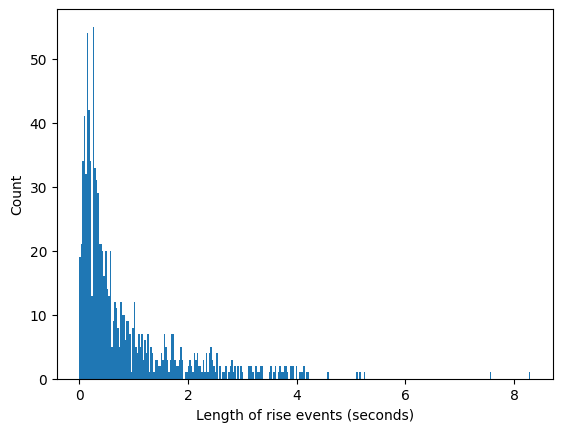

In [225]:
period_start_times, period_end_times, df = experimental._apply_velocity_threshold(expt, threshold=velocity_threshold)

**Set binning timestep (in microseconds)**

In [9]:
timestep_microseconds = int(1e5)

**Find bin edges (`sampling_times`) for all valid bins (all bins in every period where velocity > threshold)**

In [10]:
sampling_times = experimental._get_sampling_times(period_start_times, period_end_times, timestep_microseconds)

print(f"There are {len(sampling_times)} valid time periods of duration AT LEAST {timestep_microseconds} microseconds")

There are 891 valid time periods of duration AT LEAST 100000 microseconds


**Visualize thresholded sampling**

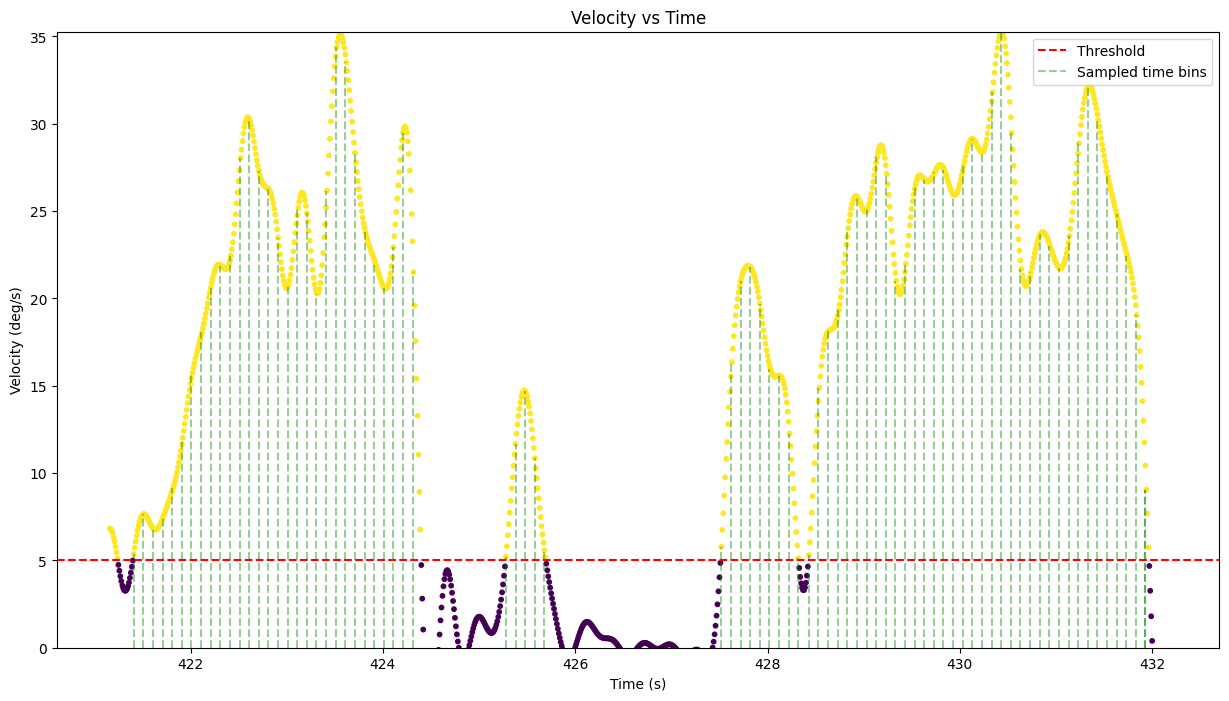

In [80]:
fig = plt.figure(figsize=(15, 8))

i_start = 6000
i_end = 7100

times_secs = df['encTimes'][i_start:i_end]*1e-6
velocities = df['vel'][i_start:i_end]
colors = df['above_threshold'][i_start:i_end]


plt.scatter(times_secs, velocities, c=colors, cmap='viridis',s=10)
plt.axhline(y=5, color='r', linestyle='--',label='Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (deg/s)')
plt.title('Velocity vs Time')
plt.ylim(0, velocities.max())


for period in sampling_times[10:14]:
    for time in period:
        ymax = df["vel"][np.searchsorted(df["encTimes"],time)]/velocities.max()
        plt.axvline(x=time*1e-6, ymax = ymax, color='green', linestyle='dashed',alpha=0.4)

plt.axvline(x=time*1e-6, ymax = ymax, color='green', linestyle=('dashed'),label='Sampled time bins',alpha=0.4)



plt.legend();

**Get the neural activity**

In [27]:
neural_activity = []

for neuron_index, neuron in enumerate(expt["x"]["clust"]):
    neuron_i_activity = []
    for times in sampling_times:
        spike_count, _ = np.histogram(neuron["ts"], bins=times)
        neuron_i_activity.extend(spike_count)
            
    neural_activity.append(neuron_i_activity)


neural_activity = np.array(neural_activity).T

neural_activity = neural_activity/(timestep_microseconds*1e-6)


print(f"There are {neural_activity.shape[0]} data points of neural activity for this experiment.")


There are 9770 data points of neural activity for this experiment.


**Get values of laboratory variables, i.e., "labels"**

In [15]:
recorded_angles = expt["x"]["rosdata"]["encAngle"]
recorded_times = expt["x"]["rosdata"]["encTimes"]
recorded_vel = expt["x"]["rosdata"]["vel"]
recorded_gain = expt["x"]["rosdata"]["gain"]

angles = experimental._average_variable(recorded_angles, recorded_times, sampling_times)
lap = angles//360
angles = angles % 360
all_times = experimental._average_variable(recorded_times, recorded_times, sampling_times)
velocities = experimental._average_variable(recorded_vel, recorded_times, sampling_times)
gains = experimental._average_variable(recorded_gain, recorded_times, sampling_times)


labels = pd.DataFrame(
    {
        "times": all_times,
        "lap": lap,
        "angles": angles,
        "velocities": velocities,
        "gains": gains,
    }
)

## Load neural activity & labels
Using `neuralgeom.datasets.experimental.load_neural_activity`

In [100]:
import neuralgeom.datasets.experimental as experimental

expt_id = "34"
timestep_microsec = int(2e5)
vel_threshold = 5

neural_activity, labels = experimental.load_neural_activity(expt_id=expt_id, vel_threshold= vel_threshold, timestep_microsec=timestep_microsec)

times_in_seconds = labels["times"]*1e-6
angles = labels["angles"]

print(f"There are {neural_activity.shape[1]} neurons binned over {neural_activity.shape[0]} timesteps")

INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_times_timestep200000_velthreshold_5.txt! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_neural_activity_timestep200000_velthreshold_5.npy! Loading...
INFO: # - Found file at /Users/facosta/Desktop/code/neuralgeom/neuralgeom/data/binned/expt34_labels_timestep200000_velthreshold_5.txt! Loading...


There are 40 neurons binned over 3655 timesteps


Visualize activity over time (PSTH) -- no speed thresholding

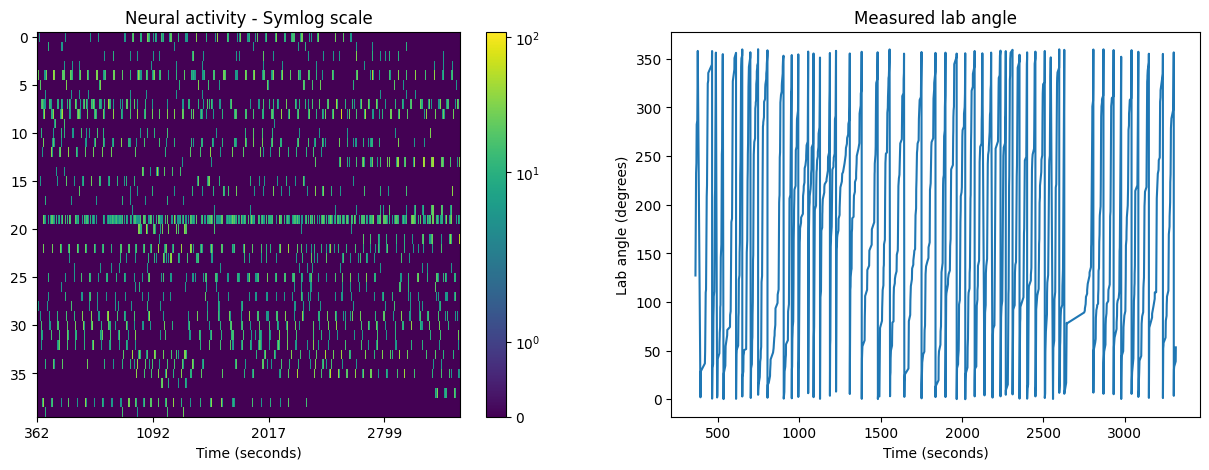

In [57]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))

psth = axs[0].imshow(neural_activity.T, aspect="auto",cmap="viridis",norm="symlog",interpolation="none")
axs[0].set_title("Neural activity - Symlog scale")
axs[0].set_xticks(np.arange(len(times_in_seconds))[::1000])
axs[0].set_xticklabels(times_in_seconds[::1000].astype(int))
axs[0].set_xlabel("Time (seconds)")

fig.colorbar(psth,ax=axs[0])

axs[1].plot(times_in_seconds, angles)
axs[1].set_xlabel("Time (seconds)")
axs[1].set_ylabel("Lab angle (degrees)")
axs[1].set_title("Measured lab angle");

## Calculate Mutual Information between angular position and activity for each neuron

!!!!!TODO!!!!!: 

Look for existing implementation of multivariate mutual information

For now: account for topology of task by definining mutual information between position $\theta$ and neural activity $r_i$ of neuron $i$ as:

$$ \text{MI}(r_i,\theta) \equiv \text{MI}(r_i,\cos{\theta}) + \text{MI}(r_i,\sin{\theta}) $$


where $$ \text{MI}(X,Y) = \text{KL}(p_{XY}(x,y)||p_X(x)p_Y(y)) = \int \int  \ \textrm{d}x \ \textrm{d}y \ p_{XY}(x,y) \log{\frac{p_{XY}(x,y)}{p_X(x)p_Y(y)}}$$


What are other tests of independence/ correlation coefficiens?

See:
- https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138
- https://arxiv.org/pdf/1307.7383.pdf
- https://arxiv.org/pdf/1909.10140.pdf
- https://github.com/minepy/mictools

In [101]:
from sklearn.feature_selection import mutual_info_regression
angles_radians = angles*np.pi/180

X = np.cos(angles_radians)
Y = np.sin(angles_radians)

spatial_mutual_info_X = mutual_info_regression(neural_activity,X)
spatial_mutual_info_Y = mutual_info_regression(neural_activity,Y)
spatial_mutual_info_XY = spatial_mutual_info_X + spatial_mutual_info_Y

**Visualize peristimulus angle histogram (PSAH) with individual spatial mutual information score**

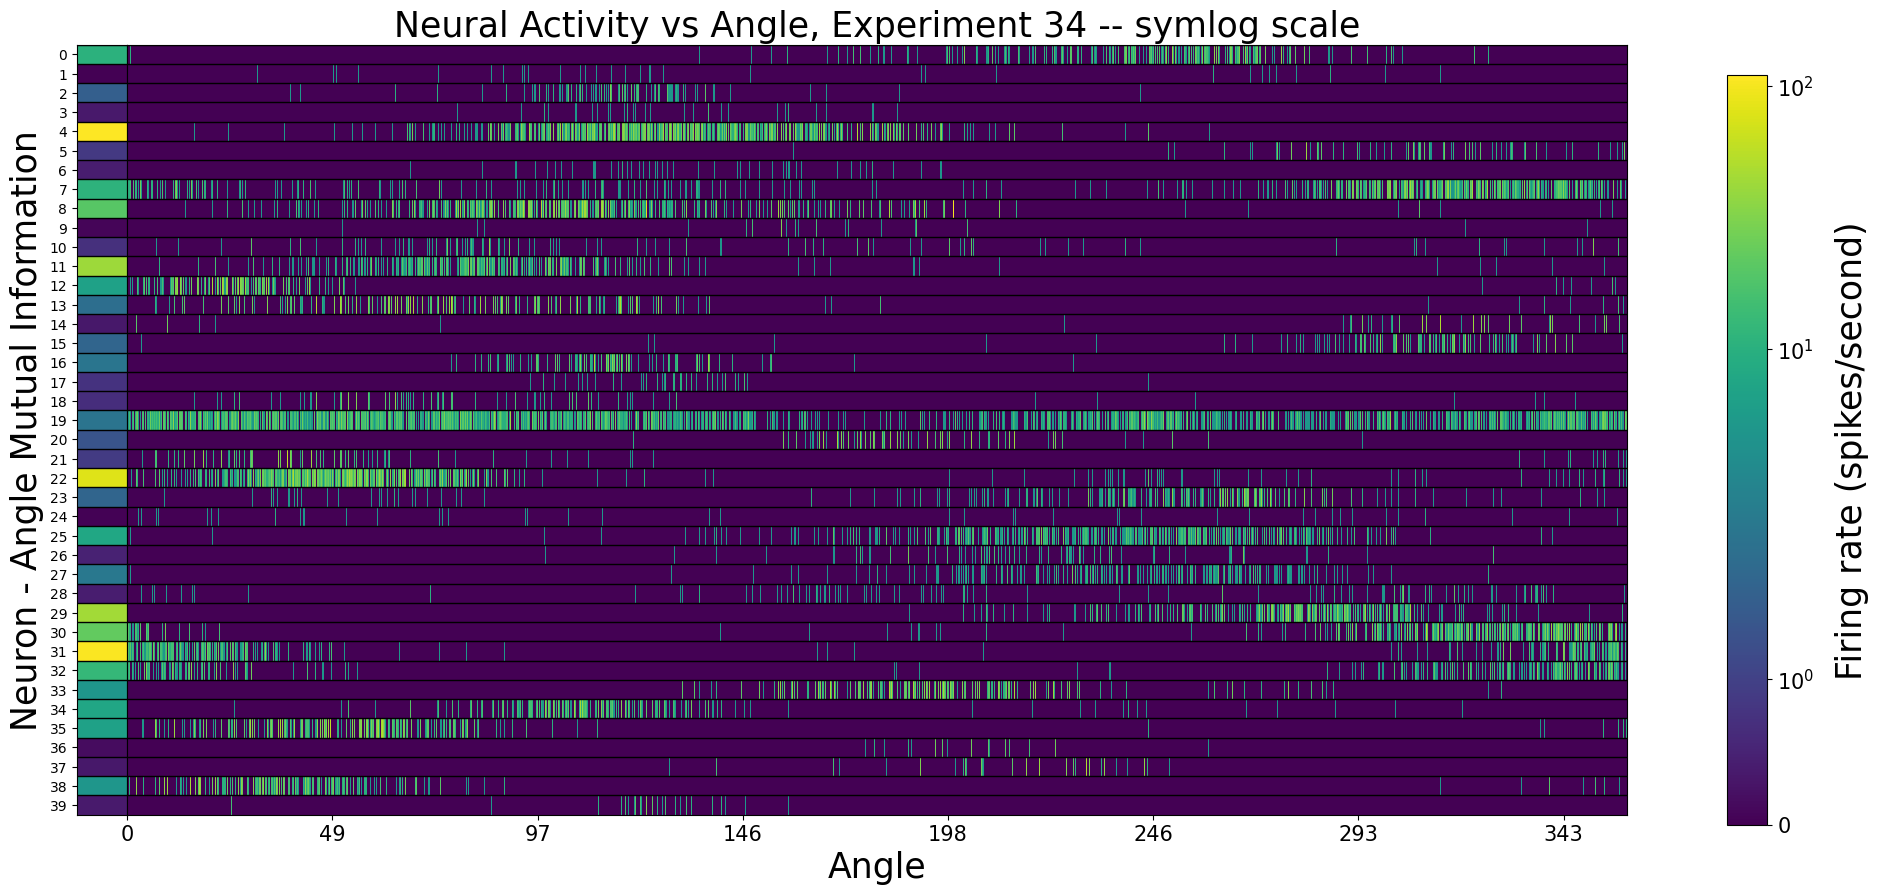

In [102]:
import viz

sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_neural_activity = neural_activity[sort, :]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=sorted_neural_activity,task_variable=sorted_angles,mutual_info=spatial_mutual_info_XY,norm="symlog")

Set Spatial Mutual Information threshold

there are 16 neurons with spatial information above 0.15


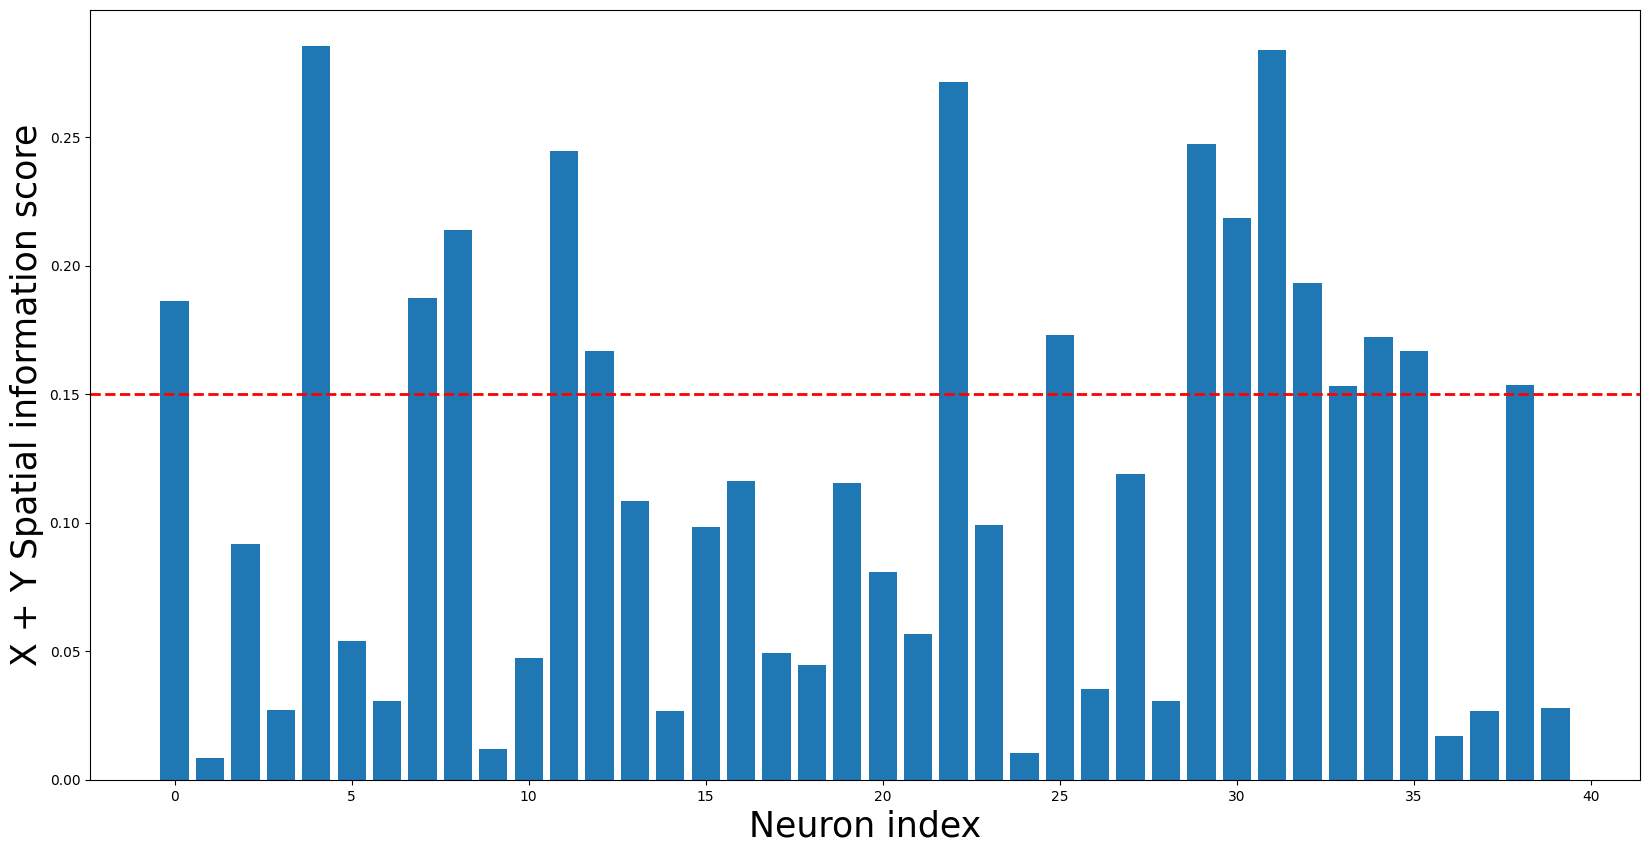

In [109]:
mi_threshold = 0.15

mi_thresh_neural_activity = neural_activity[:,spatial_mutual_info_XY>mi_threshold]
mi_thresh_spatial_mutual_info = spatial_mutual_info_XY[spatial_mutual_info_XY>mi_threshold]

x_ticks = np.arange(0,len(spatial_mutual_info_XY))

fig, axs = plt.subplots(figsize=(20,10))

axs.bar(x_ticks, spatial_mutual_info_XY)
axs.set_xlabel("Neuron index",fontsize=25)
axs.set_ylabel("X + Y Spatial information score",fontsize=25)
axs.axhline(mi_threshold, color='red', lw=2, linestyle='--',label="MI threshold");

print(f"there are {len(mi_thresh_spatial_mutual_info)} neurons with spatial information above {mi_threshold}")

## Visualize high MI neurons, organized by place field centers

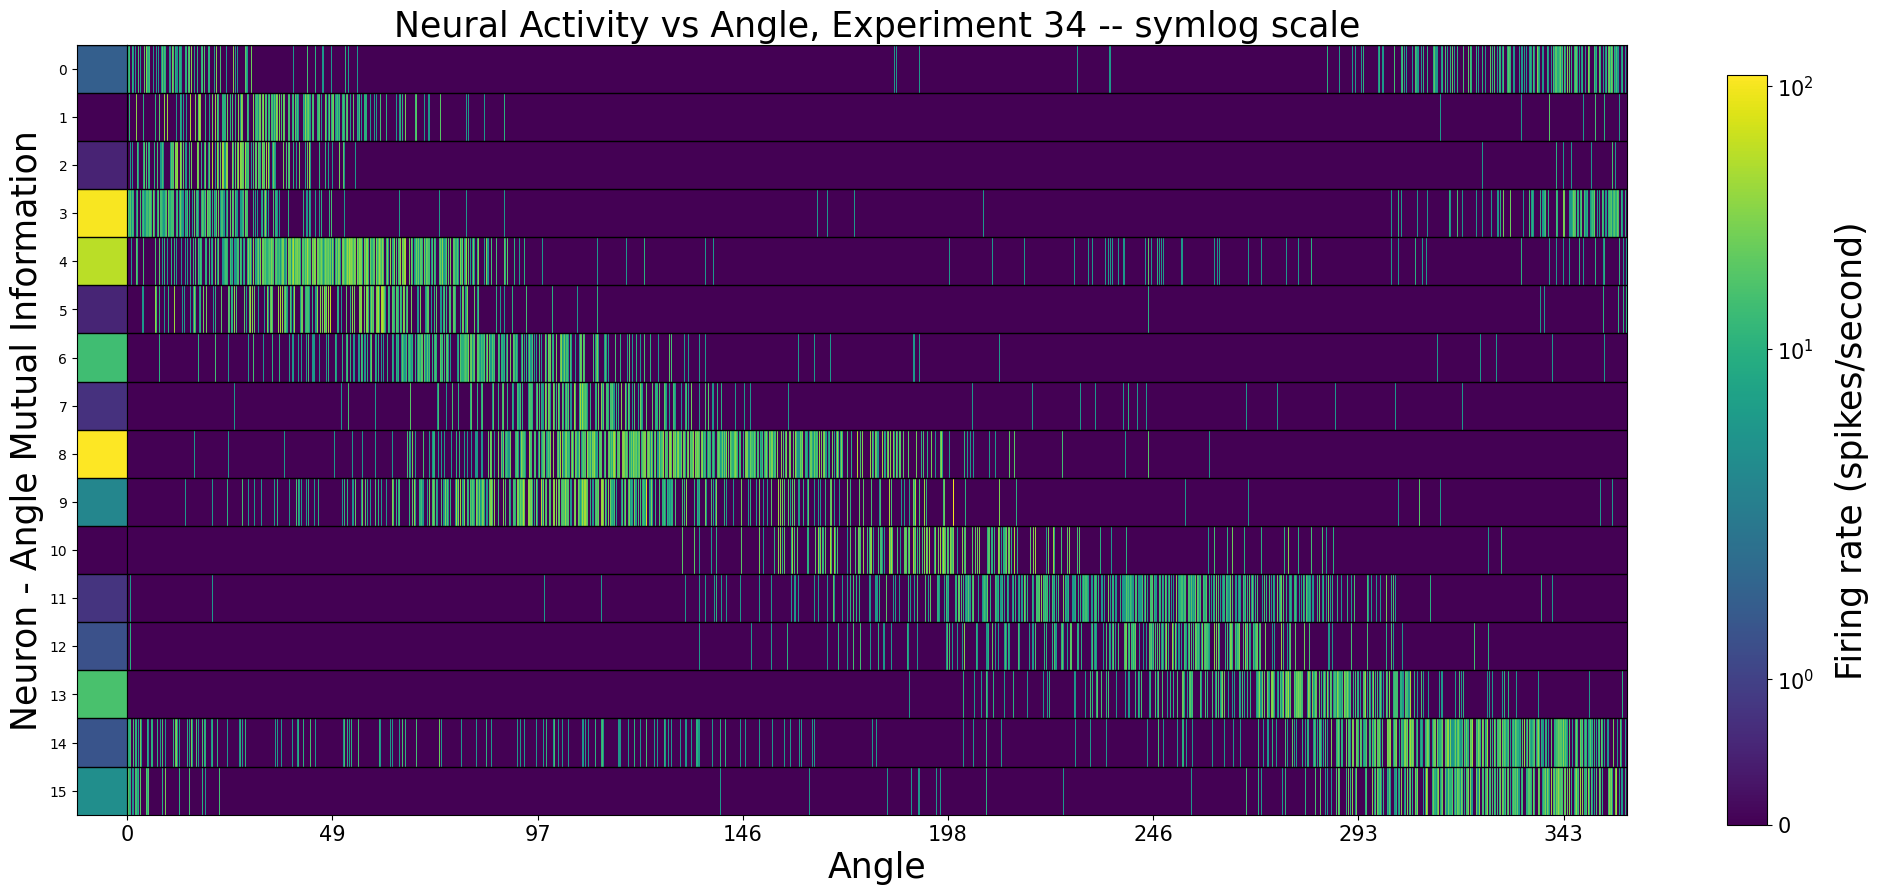

In [110]:
sort = np.argsort(angles)
sorted_angles = np.array(angles)[sort]
sorted_mi_thresh_neural_activity = mi_thresh_neural_activity[sort, :]

center_of_mass, center_of_mass_indices = experimental.get_place_field_centers(sorted_mi_thresh_neural_activity, sorted_angles)
com_sort = np.argsort(center_of_mass_indices)

organized_neural_activity = sorted_mi_thresh_neural_activity[:,com_sort]
organized_spatial_mutual_info = mi_thresh_spatial_mutual_info[com_sort]

viz.plot_activity_with_mi(expt_id=expt_id,name="Angle",neural_activity=organized_neural_activity,task_variable=sorted_angles,mutual_info=organized_spatial_mutual_info)

## Visualize 3D projection of neural state space (3 neurons with adjacent place fields)

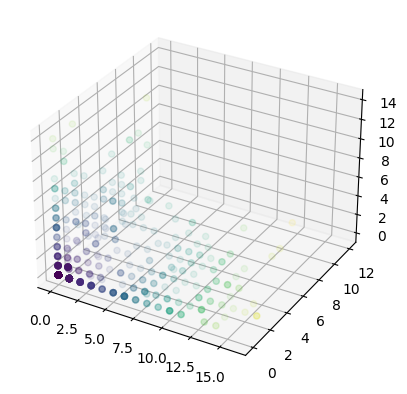

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

neuron_x_id = 5
neuron_y_id = 6
neuron_z_id = 7


x = organized_neural_activity[:,neuron_x_id]
y = organized_neural_activity[:,neuron_y_id]
z = organized_neural_activity[:,neuron_z_id]

radius = np.sqrt(x**2 + y**2 + z**2)

ax.scatter(x,y,z,alpha=0.1,c=radius ,cmap="viridis");

## Different approach: Smoothing spikes (instead of binning)

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Assume we know the total recording duration and spike times are in seconds
total_duration = 100  # total duration of recording in seconds
spike_times = np.array([0.1, 0.2, 0.35, 1.2, 1.8, 2.5, 3.0, 3.5, 3.7, 4.6, 7.8, 9.5, 20.1, 21.3, 22.6, 23.5, 50.5, 70.3, 80.2, 99.6])  # spike times

# We convert the spike times into a binary spike train
spike_train = np.zeros(int(total_duration*1000))  # millisecond resolution
spike_train[(spike_times * 1000).astype(int)] = 1

# Define the Gaussian kernel
def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x = np.arange(-size, size+1)
    g = np.exp(-(x**2) / (2*sigma**2))
    return g / np.sum(g)

# Set the parameters for the Gaussian kernel
size = 5000 # size of the kernel
sigma = 1000  # standard deviation for the Gaussian kernel

# Create the Gaussian kernel
kernel = gaussian_kernel(size, sigma)

# Convolve the spike train with the Gaussian kernel
smoothed_data = signal.convolve(spike_train, kernel, mode='same')

# Plot original and smoothed data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(spike_train)
plt.title('Original spike train')

plt.subplot(1, 2, 2)
plt.plot(smoothed_data)
plt.title('Smoothed spike train')

plt.tight_layout()
plt.show()